In [1]:
import torch
torch.manual_seed(38)
from torch.utils.data import Dataset, DataLoader
from evaluate import evaluate
from model_utils import load_checkpoint
import net
from data_loader import *
import torch.optim as optim
import torch.nn as nn
import os
import cv2
import sys
sys.path.append("..")
from utils import adjustColor, plot_histogram_normalized, print_stat
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('../Google_HDRplus/')
from hdrplus import HDRPlus_model
import json

In [2]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args("")
with open('args.json', 'r') as f:
    args.__dict__ = json.load(f)
print(args)

Namespace(alternate_corr=False, ckpt_dir='ckpt/0929_12_08', logs_dir='runs/0929_12_08', merge_ver='m', mixed_precision=False, model_dir='.', restore_file=None, small=False)


In [3]:
model = net.Net(args).cuda()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 1e-4)
loss_fn = nn.L1Loss()

In [4]:
restore_path = os.path.join('ckpt/0929_12_08/', 'last.pth.tar')

# 0922_20_45 : merge_mask
# 0928_19_43 : merge_mask w/ RAFT
# 0929_12_08 : merge_mask w/ RAFT train on larger dataset
model, optimizer, start_epoch, best_val_loss = load_checkpoint(restore_path, model, optimizer)

[*] Loaded model from ckpt/0929_12_08/last.pth.tar


In [5]:
eval_transformer =  GroupComposed([
    GroupToPILImage(mode = 'L'),
#     GroupRawRandomCrop(2048), ## random crop may cause broken Bayer pattern
    GroupToTensor()
])
# dataloader = DataLoader(HDRDataset(eval_transformer, 1),
#                             batch_size = 1, shuffle = True,
#                             num_workers = int(8),
#                             pin_memory=True)
dataloader =  DataLoader(LlrawSet(transform = eval_transformer, frame_per_sample = 16, pos = 'mid'),
                 batch_size = 1, shuffle = True,
                 num_workers = int(8),
                 pin_memory=True)
dataiter = iter(dataloader)

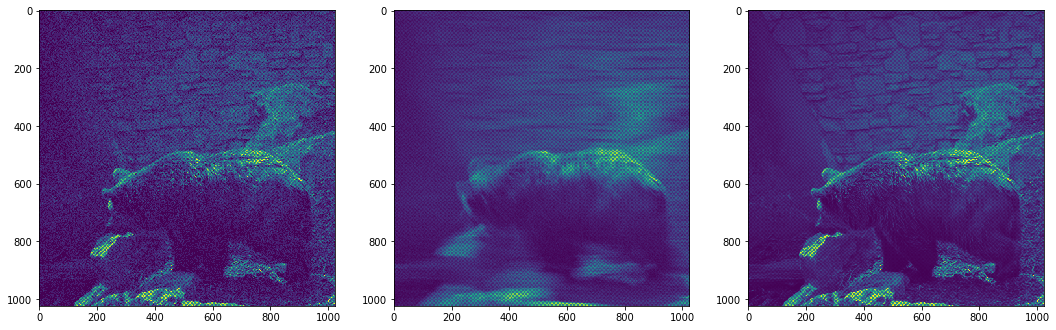

In [25]:
# for i in range(50):
val_batch, labels_batch = dataiter.next()
val_batch = val_batch[:, :, :1024, :1024]
labels_batch = labels_batch[:, :, :1024, :1024]

ref = val_batch[0, 0].numpy()
avg = np.mean(val_batch[0, :].numpy(), axis = 0)
gt = labels_batch[0, 0].cpu().numpy()
fig, ax = plt.subplots(1, 3, figsize=(18, 10)) ## different figure size may lead to block-like display. Dont know why.
ax[0].imshow(ref)
ax[1].imshow(avg)
ax[2].imshow(gt)
plt.show()

## Ground Truth

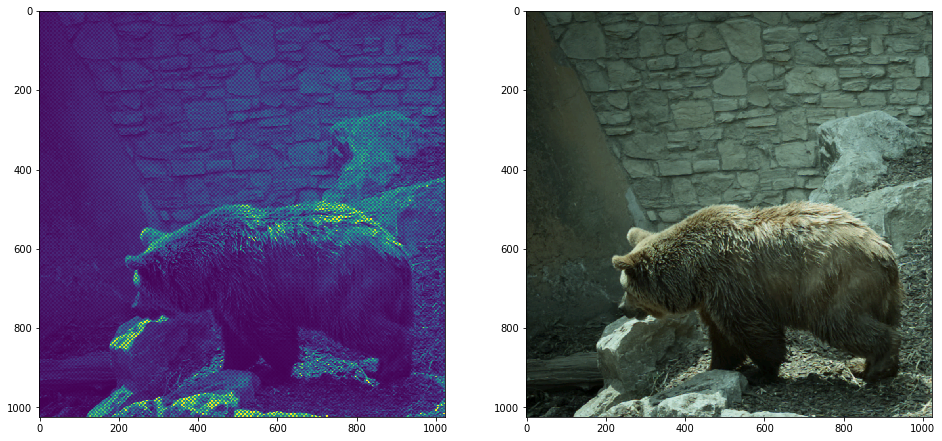

In [26]:
# rgb_gt = demosaic(gt)
rgb_gt = cv2.cvtColor((gt*255.0).astype(np.uint8), cv2.COLOR_BAYER_BG2RGB)
rgb_gt = adjustColor(rgb_gt,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(gt)
ax[1].imshow(rgb_gt)
plt.show()

gt shape:  (1024, 1024) dtype: float32
gt stat: max: 1.0, min: 0.0, mean: 0.14981354773044586, std: 0.1304846853017807


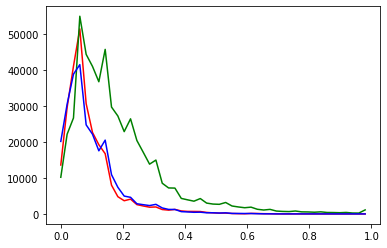

In [27]:
print_stat("gt", gt)
plot_histogram_normalized(gt)

## prediction

In [28]:
cuda=True
model.eval()

with torch.no_grad():
#     for i, (val_batch, labels_batch) in enumerate(dataloader):
#         val_batch = val_batch[:, :, :1024, :1024]
#         labels_batch = labels_batch[:, :, :1024, :1024]
    n_seq = val_batch.size(1)
    output_batch = val_batch[:, 0:1].clone()
    if cuda:
        output_batch = output_batch.cuda(non_blocking=True)
    for j in range(1, n_seq):
        print("processing {}th image....".format(j))
        input_batch = torch.cat([val_batch[:, 0:1], val_batch[:, j:j+1]], dim = 1)
        if cuda:
            input_batch, labels_batch = input_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)
        res = model(input_batch)
#                 output_batch = res
        output_batch += res.detach()
#             #########
#             output_batch = torch.sigmoid(output_batch)
    output_batch = output_batch/float(n_seq)

processing 1th image....
processing 2th image....
processing 3th image....
processing 4th image....
processing 5th image....
processing 6th image....
processing 7th image....
processing 8th image....
processing 9th image....
processing 10th image....
processing 11th image....
processing 12th image....
processing 13th image....
processing 14th image....
processing 15th image....


In [29]:
# ref = val_batch[0, 0].numpy()
# avg = np.mean(val_batch[0, :].numpy(), axis = 0)

# gt = labels_batch[0, 0].cpu().numpy()
# fig, ax = plt.subplots(1, 3, figsize=(18, 10)) ## different figure size may lead to block-like display. Dont know why.
# ax[0].imshow(ref)
# ax[1].imshow(output)
# ax[2].imshow(gt)
# plt.show()

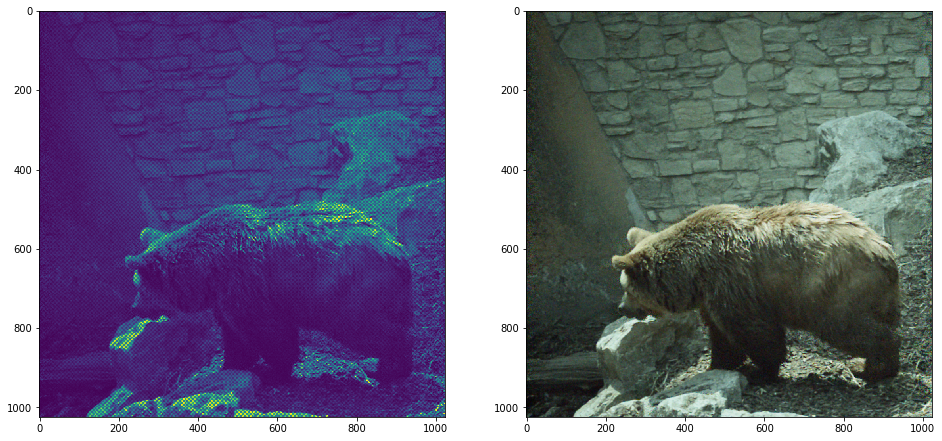

In [30]:
output = output_batch[0, 0].detach().cpu().numpy()
rgb_output = cv2.cvtColor((output*255.0).astype(np.uint8), cv2.COLOR_BAYER_BG2RGB)
rgb_output = adjustColor(rgb_output,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(output)
ax[1].imshow(rgb_output)
plt.show()

output shape:  (1024, 1024) dtype: float32
output stat: max: 1.0, min: 3.0033892471692525e-05, mean: 0.14997141063213348, std: 0.12634049355983734


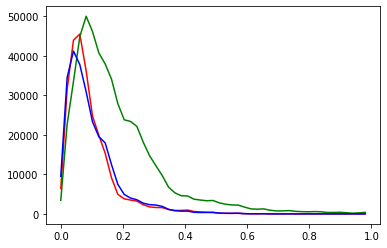

In [31]:
print_stat("output", output)
plot_histogram_normalized(output)

## 16 frames average

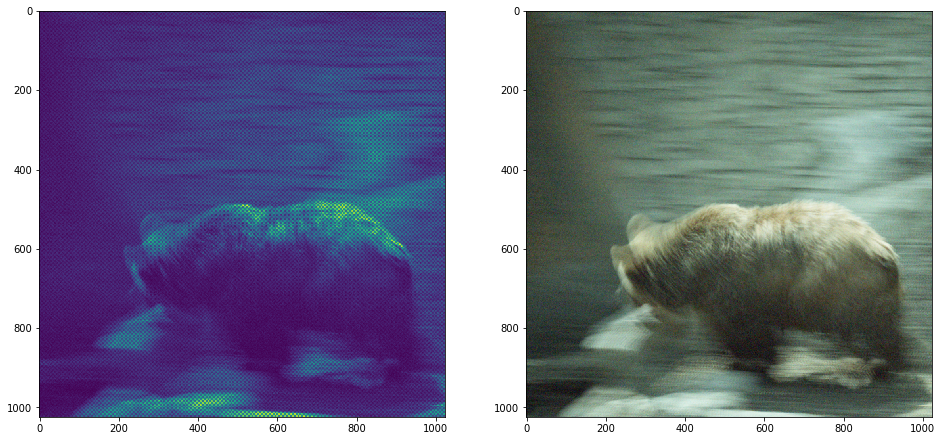

In [32]:
rgb_avg = cv2.cvtColor((avg*255.0).astype(np.uint8), cv2.COLOR_BAYER_BG2RGB)
rgb_avg = adjustColor(rgb_avg,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(avg)
ax[1].imshow(rgb_avg)
plt.show()

avg shape:  (1024, 1024) dtype: float32
avg stat: max: 0.8855468034744263, min: 0.0, mean: 0.14667241275310516, std: 0.10521218180656433


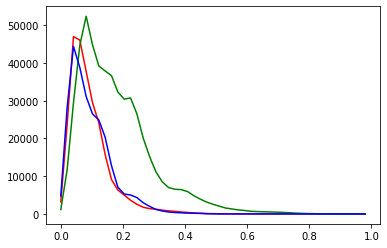

In [33]:
print_stat("avg", avg)
plot_histogram_normalized(avg)

## single frame

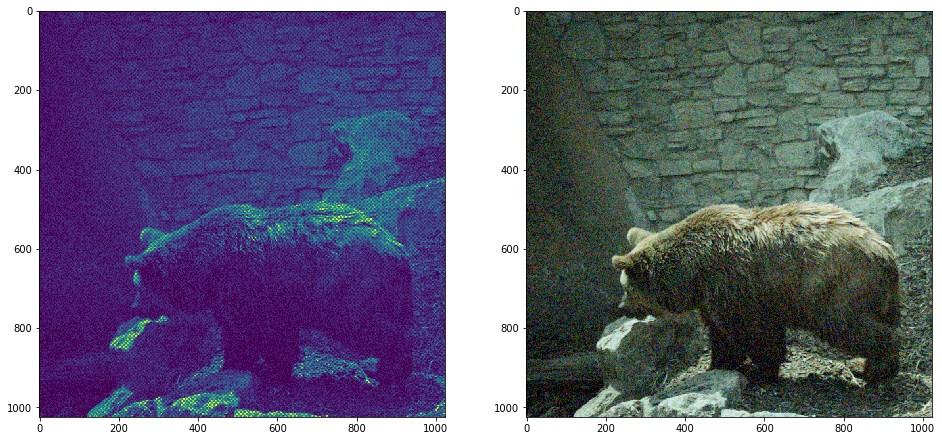

In [34]:
rgb_ref = cv2.cvtColor((ref*255.0).astype(np.uint8), cv2.COLOR_BAYER_BG2RGB)
rgb_ref = adjustColor(rgb_ref,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(ref)
ax[1].imshow(rgb_ref)
plt.show()

ref shape:  (1024, 1024) dtype: float32
ref stat: max: 1.0, min: 0.0, mean: 0.14162573218345642, std: 0.13282383978366852


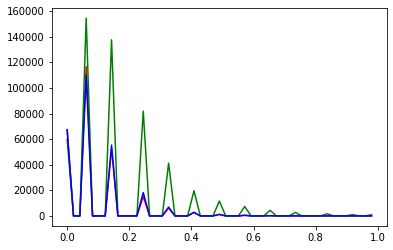

In [35]:
print_stat("ref", ref)
plot_histogram_normalized(ref)

## HDRPlus

In [36]:
# dataiter = iter(dataloader)
# val_batch, labels_batch = dataiter.next()
# val_batch = val_batch#[:, :, :2048, :3584]
# labels_batch = labels_batch#[:, :, :2048, :3584]
val_imgs = (val_batch[0].numpy() * 28.0).astype(np.int16)
output_hdrplus = HDRPlus_model(val_imgs)

merging 1th alternative frame
merging 2th alternative frame
merging 3th alternative frame
merging 4th alternative frame
merging 5th alternative frame
merging 6th alternative frame
merging 7th alternative frame
merging 8th alternative frame
merging 9th alternative frame
merging 10th alternative frame
merging 11th alternative frame
merging 12th alternative frame
merging 13th alternative frame
merging 14th alternative frame
merging 15th alternative frame


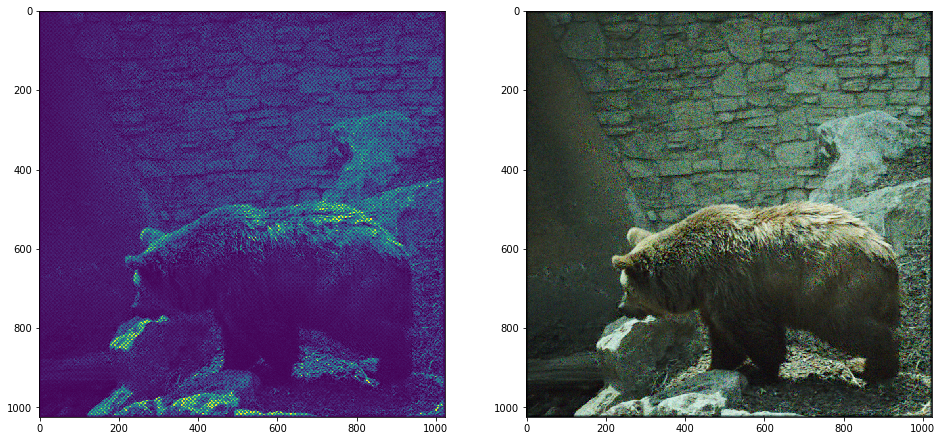

In [37]:
rgb_hdrp = cv2.cvtColor((output_hdrplus/output_hdrplus.max()*255.0).astype(np.uint8), cv2.COLOR_BAYER_BG2RGB)
rgb_hdrp = adjustColor(rgb_hdrp,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(output_hdrplus)
ax[1].imshow(rgb_hdrp)
plt.show()

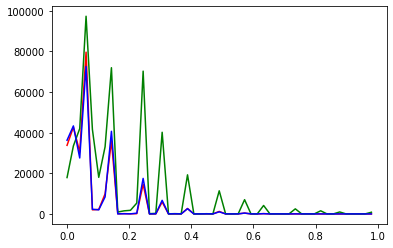

In [38]:
plot_histogram_normalized(output_hdrplus/output_hdrplus.max())

## comparison

From left to right: ref, hdr+ frame, pred frame, gt

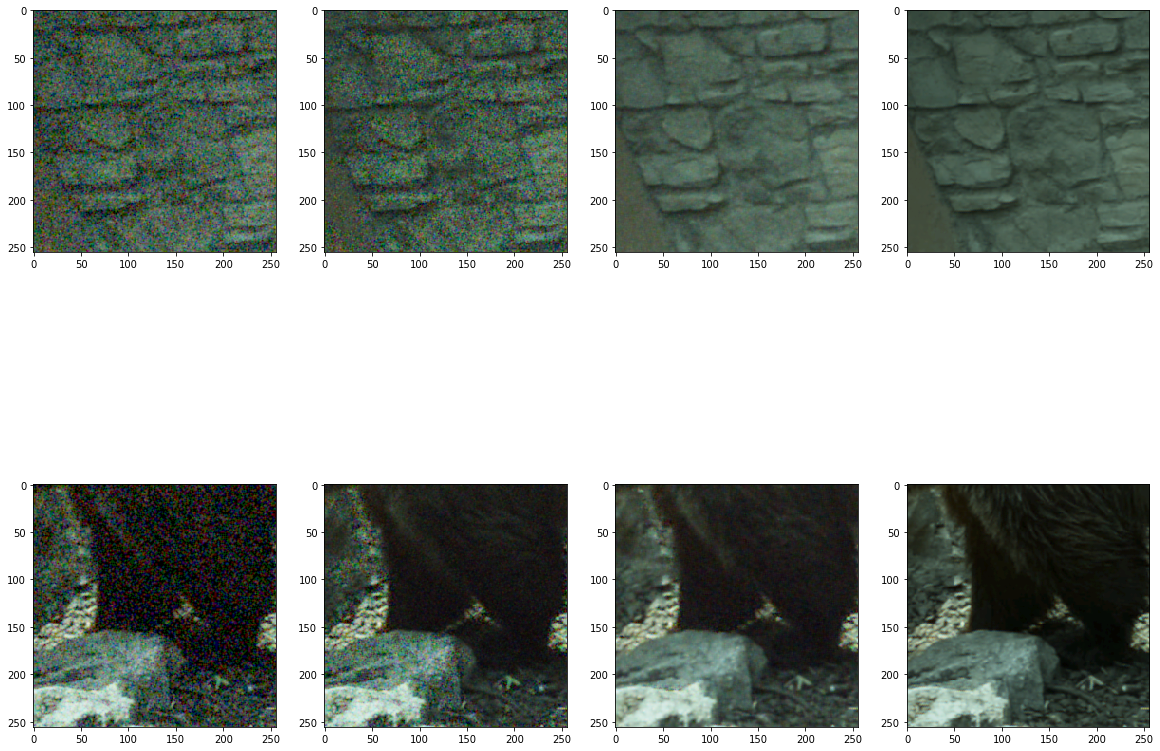

In [39]:
fig, ax = plt.subplots(2, 4, figsize=(20, 16))
ax[0][0].imshow(rgb_ref[100:100+256, 155:155+256])
ax[0][1].imshow(rgb_hdrp[100:100+256, 155:155+256])
ax[0][2].imshow(rgb_output[100:100+256, 155:155+256])
ax[0][3].imshow(rgb_gt[100:100+256, 155:155+256])
ax[1][0].imshow(rgb_ref[750:750+256, 400:400+256])
ax[1][1].imshow(rgb_hdrp[750:750+256, 400:400+256])
ax[1][2].imshow(rgb_output[750:750+256, 400:400+256])
ax[1][3].imshow(rgb_gt[750:750+256, 400:400+256])
plt.show()

In [40]:
# fig, ax = plt.subplots(2, 4, figsize=(20, 16))
# ax[0][0].imshow(rgb_ref[1000:1000+256, 1550:1550+256])
# ax[0][1].imshow(rgb_hdrp[1000:1000+256, 1550:1550+256])
# ax[0][2].imshow(rgb_output[1000:1000+256, 1550:1550+256])
# ax[0][3].imshow(rgb_gt[1000:1000+256, 1550:1550+256])
# ax[1][0].imshow(rgb_ref[1750:1750+256, 1100:1100+256])
# ax[1][1].imshow(rgb_hdrp[1750:1750+256, 1100:1100+256])
# ax[1][2].imshow(rgb_output[1750:1750+256, 1100:1100+256])
# ax[1][3].imshow(rgb_gt[1750:1750+256, 1100:1100+256])
# # ax[2][0].imshow(rgb_hdrp[1500:1500+256, 2100:2100+256])
# # ax[2][1].imshow(rgb_output[1500:1500+256, 2100:2100+256])
# # ax[2][2].imshow(rgb_gt[1500:1500+256, 2100:2100+256])
# plt.show()